In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
# Raw Data
df = pd.read_csv('../data/raw/rating.csv')
df.head(5)

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [3]:
# Train Data (subset of all interactions)
df = pd.read_csv('../data/interactions_train_df.csv')
df = df[['user_id', 'content_id', 'game', 'view']]
df.head(5)

,user_id,content_id,game,view
0,134,1680,Far Cry 3 Blood Dragon,1
1,2219,1938,Gone Home,1
2,3315,3711,Serious Sam 3 BFE,1
3,3440,4784,Velvet Sundown,1
4,870,4104,Super Hexagon,1


In [4]:
# Content Data of Games
df_game = pd.read_csv('../data/articles_df.csv')
df_game.head(4)

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9


### Create a Matrix of Interactions

In [5]:
# Creating a sparse pivot table with users in rows and items in columns
users_items_matrix_df = df.pivot(index   = 'user_id', 
                                 columns = 'content_id', 
                                 values  = 'view').fillna(0)
users_items_matrix_df.head(10)

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
users_items_matrix_df.shape

(3757, 4862)

In [7]:
users_items_matrix_df.values.mean()*100

0.5042609616033342

## Model

In [8]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [9]:
# input
X = users_items_matrix_df.values
y = users_items_matrix_df.values

In [10]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       (None, 4862)              0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               2489856   
_________________________________________________________________
LatentSpace (Dense)          (None, 256)               131328    
_________________________________________________________________
Dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               131584    
_________________________________________________________________
UserScorePred (Dense)        (None, 4862)              2494206   
Total params: 5,246,974
Trainable params: 5,246,974
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [11]:
hist = model.fit(x=X, y=y,
                  epochs=50,
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

Train on 3381 samples, validate on 376 samples
Epoch 1/50
3381/3381 [==============================] - 6s 2ms/step - loss: 0.0282 - val_loss: 0.0038
Epoch 2/50
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0183 - val_loss: 0.0031
Epoch 3/50
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0137 - val_loss: 0.0027
Epoch 4/50
3381/3381 [==============================] - 3s 1ms/step - loss: 0.0111 - val_loss: 0.0025
Epoch 5/50
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0023
Epoch 6/50
3381/3381 [==============================] - 3s 1ms/step - loss: 0.0083 - val_loss: 0.0022
Epoch 7/50
3381/3381 [==============================] - 3s 1ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 8/50
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0069 - val_loss: 0.0021
Epoch 9/50
3381/3381 [==============================] - 4s 1ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 10/50
3381/3381 [============

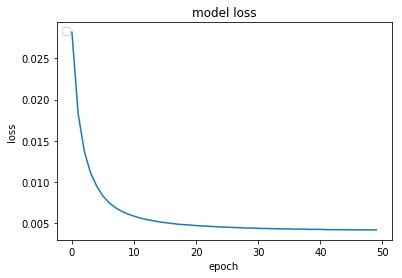

In [21]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

## Recommender

In [13]:
# Predict new Matrix Interactions, set score zero on visualized games
new_matrix = model.predict(X) * (X == 0)

In [14]:
# converting the reconstructed matrix back to a Pandas dataframe
new_users_items_matrix_df  = pd.DataFrame(new_matrix, 
                                          columns = users_items_matrix_df.columns, 
                                          index   = users_items_matrix_df.index)
new_users_items_matrix_df.head()

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
user_id,,,,,,,,,,,,,,,,,,,,,
0,-0.002197,-0.001979,-0.000805,0.002296,-0.000611,-0.008840,-0.007028,0.005476,-0.003611,-0.001567,...,-0.007693,-0.002160,-0.001630,-0.007251,0.003084,-0.019969,0.004092,-0.004482,-0.015626,0.000907
1,0.000652,0.002933,0.007499,-0.008718,-0.004078,-0.001739,0.000383,0.018262,-0.013793,0.018117,...,-0.009904,-0.012572,-0.009873,-0.005511,-0.000534,-0.003477,-0.008922,-0.003647,0.029548,-0.002062
2,0.004266,-0.004423,0.004111,0.011979,-0.013828,0.016206,-0.013307,0.017889,-0.008861,0.005887,...,-0.014347,-0.002823,0.006762,0.028751,0.006827,0.032240,-0.001731,-0.000366,0.003056,0.017550
3,0.004046,0.001116,0.002487,-0.000940,-0.000210,0.002233,-0.000304,0.005891,-0.004261,0.001885,...,0.005553,-0.000322,0.002608,-0.003137,-0.002550,0.007719,0.000484,-0.007889,-0.000531,-0.002881
4,0.005502,-0.000663,-0.001771,-0.001596,-0.000134,0.005894,0.002674,0.004908,-0.000602,-0.003510,...,0.003261,0.001340,0.000516,0.000465,-0.000046,0.006702,0.002666,-0.004489,0.011630,-0.004099


In [15]:
print(new_users_items_matrix_df.values.min(), new_users_items_matrix_df.values.max())

-0.49707025 1.4381734


In [16]:
def recommender_for_user(user_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Games for UserWarning
    '''
    pred_scores = interact_matrix.loc[user_id].values

    df_scores   = pd.DataFrame({'content_id': list(users_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('content_id')\
                    .join(df_content.set_index('content_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'game']]
    
    return df_rec[df_rec.score > 0]

Recommender for **user_id = 1011**. This user prefers games in the same half-life line

In [17]:
# Games previously purchased by the user
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
3196,1.0,Portal
4221,1.0,Team Fortress 2
2055,1.0,Half-Life 2
2057,1.0,Half-Life 2 Episode One
2059,1.0,Half-Life 2 Lost Coast


In [18]:
# Recommended User Games
recommender_for_user(
    user_id         = 1011, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
2058,0.267165,Half-Life 2 Episode Two
2056,0.251573,Half-Life 2 Deathmatch
978,0.175254,Counter-Strike Source
2062,0.161243,Half-Life Deathmatch Source
3197,0.134333,Portal 2
1126,0.098420,Day of Defeat Source
2064,0.095502,Half-Life Source
2457,0.093733,Left 4 Dead 2
2456,0.074682,Left 4 Dead


Recommender for **user_id = 1319**. This user prefers games in the same line as the RPG or strategy

In [19]:
# Games previously purchased by the user
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
173,1.0,Age of Empires II HD Edition
2662,1.0,Medieval II Total War Kingdoms
4331,1.0,The Elder Scrolls V Skyrim - Hearthfire
4329,1.0,The Elder Scrolls V Skyrim - Dawnguard
4626,1.0,Total War ATTILA
1752,1.0,Football Manager 2015
4272,1.0,The Bard's Tale
4631,1.0,Total War SHOGUN 2
4328,1.0,The Elder Scrolls V Skyrim


In [22]:
# Recommended User Games
recommender_for_user(
    user_id         = 1319, 
    interact_matrix = new_users_items_matrix_df, 
    df_content      = df_game)

,score,game
content_id,,
4330,0.292329,The Elder Scrolls V Skyrim - Dragonborn
3792,0.151435,Sid Meier's Civilization V
3837,0.146657,Skyrim High Resolution Texture Pack
4630,0.108521,Total War ROME II - Emperor Edition
1490,0.105798,Empire Total War
1667,0.093142,Fallout New Vegas
2872,0.091419,Napoleon Total War
3793,0.083783,Sid Meier's Civilization V Brave New World
1668,0.077532,Fallout New Vegas Courier's Stash
